ECEN 743: Reinforcement Learning
Deep Q-Learning
Code tested using
	1. gymnasium 0.27.1
	2. box2d-py  2.3.5
	3. pytorch   2.0.0
	4. Python    3.9.12
1 & 2 can be installed using pip install gymnasium[box2d]
General Instructions
1. This code consists of TODO blocks, read them carefully and complete each of the blocks
2. Type your code between the following lines
			###### TYPE YOUR CODE HERE ######
			#################################
3. The default hyperparameters should be able to solve LunarLander-v2
4. You do not need to modify the rest of the code for this assignment, feel free to do so if needed.

In [1]:
%pip install gymnasium[all]

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Harsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip3 install torch

You should consider upgrading via the 'C:\Users\Harsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [3]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import base64, io
import cv2
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [4]:
import torch
torch.cuda.is_available()

False

In [5]:
class ExperienceReplay:
	""" 
	Based on the Replay Buffer implementation of TD3 
	Reference: https://github.com/sfujim/TD3/blob/master/utils.py
	"""
	def __init__(self, state_dim, action_dim,max_size,batch_size,gpu_index=0):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0
		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.done = np.zeros((max_size, 1))		
		self.batch_size = batch_size
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')


	def add(self, state, action,reward,next_state, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.done[self.ptr] = done
		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)

	def sample(self):
		ind = np.random.randint(0, self.size, size=self.batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).long().to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.done[ind]).to(self.device)
		)



In [6]:
class QNetwork(nn.Module):
	"""
	Q Network: designed to take state as input and give out Q values of actions as output
	"""

	def __init__(self, state_dim, action_dim):
		"""
			state_dim (int): state dimenssion
			action_dim (int): action dimenssion
		"""
		super(QNetwork, self).__init__()
		self.l1 = nn.Linear(state_dim, 64)
		self.l2 = nn.Linear(64, 64)
		self.l3 = nn.Linear(64, action_dim)
		
	def forward(self, state):
		q = F.relu(self.l1(state))
		q = F.relu(self.l2(q))
		return self.l3(q)

In [7]:
class DQNAgent():

	def __init__(self,
	 state_dim, 
	 action_dim,
	 discount=0.99,
	 tau=1e-3,
	 lr=5e-4,
	 update_freq=4,
	 max_size=int(1e5),
	 batch_size=64,
	 gpu_index=0
	 ):
		"""
			state_size (int): dimension of each state
			action_size (int): dimension of each action
			discount (float): discount factor
			tau (float): used to update q-target
			lr (float): learning rate
			update_freq (int): update frequency of target network
			max_size (int): experience replay buffer size
			batch_size (int): training batch size
			gpu_index (int): GPU used for training
		"""
		self.state_dim = state_dim
		self.action_dim = action_dim
		self.discount = discount
		self.tau = tau
		self.lr = lr
		self.update_freq = update_freq
		self.max_size = max_size
		self.batch_size = batch_size
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')


		# Setting up the NNs
		self.Q = QNetwork(state_dim, action_dim).to(self.device)
		self.Q_target = QNetwork(state_dim, action_dim).to(self.device)
		self.optimizer = optim.Adam(self.Q.parameters(), lr=self.lr)

		# Experience Replay Buffer
		self.memory = ExperienceReplay(state_dim,1,max_size,self.batch_size,gpu_index)
		
		self.t_train = 0
	
	def step(self,experienced, targeted, state, action, reward, next_state, done):
		self.t_train += 1			
		self.memory.add(state, action, reward, next_state, done)
		if experienced and targeted:
			if self.memory.size > self.batch_size:
					   
				
				experiences = self.memory.sample()
				self.learn(experiences, self.discount) #To be implemented
			if (self.t_train % self.update_freq) == 0:
				self.target_update(self.Q, self.Q_target, self.tau) #To be implemented
		elif experienced and not targeted:
			if self.memory.size > self.batch_size:
				self.memory.add(state, action, reward, next_state, done)	   
			
				experiences = self.memory.sample()
				self.learn_with_experience_replay_without_target_network(experiences, self.discount) #To be implemented
		else:
			if self.memory.size > self.batch_size:
				self.learn_without_experience_replay_with_target_network(state, action, reward, next_state, done, self.discount)
			if (self.t_train % self.update_freq) == 0:
				self.target_update(self.Q, self.Q_target, self.tau)
		
 

	def select_action(self, state, epsilon = 0.):
		if np.random.random() > epsilon:
			state = torch.tensor(state, dtype=torch.float32, device=self.device) # converting our state to pytorch tensor
			#self.Q(state) # writing updated tensor to device
			self.Q.eval()
			with torch.no_grad():
				actions=self.Q.forward(state)
			self.Q.train()
			action = torch.argmax(actions).item()
		else:
				action=np.random.choice(self.action_dim) # Random choice of action from action space of enviornment
		
		return action

	def learn(self, experiences, discount):		
		states, actions, rewards, next_states, dones = experiences
		q_eval = self.Q(states).gather(1, actions)
		q_next = self.Q_target(next_states).detach().max(1)[0].unsqueeze(1)
		q_target = rewards + discount * q_next * (1-dones)
		loss = F.mse_loss(q_eval, q_target)
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step()        
		self.target_update(self.Q, self.Q_target, self.tau)
		
	def learn_with_experience_replay_without_target_network(self, experiences, discount):
		states, actions, rewards, next_states, dones = experiences
		q_eval = self.Q(states).gather(1, actions)
		q_next = self.Q_target(next_states).detach().max(1)[0].unsqueeze(1)
		q_target = rewards + discount * q_next * (1-dones)
		loss = F.mse_loss(q_eval, q_target)
		
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step()        
		 

	def learn_without_experience_replay_with_target_network(self, states, actions, rewards, next_states, dones, discount):
		states, actions, rewards, next_states, dones = [states], [actions], [rewards], [next_states], [dones]
		states = torch.tensor(states).float().to(self.device)
		actions = torch.tensor(actions).long().unsqueeze(1).to(self.device)  # Fix here
		rewards = torch.tensor(rewards).float().unsqueeze(1).to(self.device)  # Fix here
		next_states = torch.tensor(next_states).float().to(self.device)
		dones = torch.tensor(dones).unsqueeze(1).float().to(self.device)
		
		q_eval = self.Q(states).gather(1, actions)
		q_next = self.Q_target(next_states).detach().max(1)[0].unsqueeze(1)
		q_target = rewards + discount * q_next * (1-dones)
		loss = F.mse_loss(q_eval, q_target)
		
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step() 
		      
		self.target_update(self.Q, self.Q_target, self.tau)

	def target_update(self, Q, Q_target, tau):
		for param_target, param_local in zip(Q_target.parameters(), Q.parameters()):
  			param_target.data.copy_(tau*param_local.data + (1.0-tau)*param_target.data)

In [20]:
def trainer(experienced, targeted, render):
  seed = 0              
  n_episodes = 1200
  batch_size = 64
  discount = 0.99
  lr = 5e-4                       # learning rate
  tau = 0.001                     # soft update of target network
  max_size = int(1e5)
  update_freq = 4
  gpu_index = 0
  max_eps_len = 1000
  experience=experienced
  target= targeted
  Render=render
  #exploration strategy 
  # making the environment	
  env = gym.make("LunarLander-v2")  
  #setting seeds
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed) 
  state_dim = env.observation_space.shape[0]
  action_dim = env.action_space.n 
  kwargs = {
		"state_dim":state_dim,
		"action_dim":action_dim,
		"discount":discount,
	 	"tau":tau,
	 	"lr":lr,
	 	"update_freq":update_freq,
	 	"max_size":max_size,
	 	"batch_size":batch_size,
	 	"gpu_index":gpu_index
	}	
  learner = DQNAgent(**kwargs) #Creating the DQN learning agent  
  moving_window = deque(maxlen=100)

  Scores = []  

  epsilon_start = 1               # start value of epsilon
  epsilon_end = 0.01              # end value of epsilon
  epsilon_decay = 0.995           # decay value of epsilon	  

  epsilon_by_step = lambda step: float(epsilon_end+(epsilon_start - epsilon_end)*np.exp(-1. * step / epsilon_decay))

	 
  for e in range(n_episodes):
    state, _ = env.reset(seed=seed)
    curr_reward = 0
    for t in range(max_eps_len):
      action = learner.select_action(state, epsilon_by_step(t)) #To be implemented
      n_state,reward,terminated,truncated,_ = env.step(action)
      done = terminated or truncated 
      learner.step(experience, target, state, action, reward, n_state, done) #To be implemented
      state = n_state
      curr_reward += reward
      if done:
        break
    Scores.append(curr_reward)
    moving_window.append(curr_reward)

    """"
      TODO: Write code for decaying the exploration rate using args.epsilon_decay
      and args.epsilon_end. Note that epsilon has been initialized to args.epsilon_start  
      1. You are encouraged to try new methods
    
    """
    if Render:
      if np.mean(moving_window) > 200.00:
        torch.save(learner.Q.state_dict(), 'checkpoint.pth')
    if e % 100 == 0:
      print('Episode Number {} Average Episodic Reward (over 100 episodes): {:.2f}'.format(e, np.mean(moving_window)))

  fig1=plt.figure()
  plt.plot(np.arange(len(Scores)), Scores)
  plt.ylabel('Score')
  plt.xlabel('No of Episodes')
  if experience and target:
    plt.title('Learning curve using decaying epsilon with experience replay and target network') 
  elif experience and not target:
    plt.title('Learning curve using decaying epsilon with experience replay but without target network') 
  else:
    plt.title('Learning curve using decaying epsilon without experience replay but with target network')
  plt.show() 
  
  # slide the window over the data and compute the average at each position
  window_size=100
  averages=[]
  for i in range(len(Scores) - window_size + 1):
    window = Scores[i:i+window_size]
    average = sum(window) / window_size
    averages.append(average)
  fig2=plt.figure()  
  plt.plot(averages, color='r', label='Training Curve')
  plt.xlabel('Number of Episodes')
  plt.ylabel('Episodic Cummulative Reward')
  if experience and target:
    plt.title('Learning curve using decaying epsilon with experience replay and target network') 
  elif experience and not target:
    plt.title('Learning curve using decaying epsilon with experience replay but without target network') 
  else:
    plt.title('Learning curve using decaying epsilon without experience replay but with target network') 
  plt.legend(loc='best')
  plt.show()  





Episode Number 0 Average Episodic Reward (over 100 episodes): -121.30
Episode Number 100 Average Episodic Reward (over 100 episodes): -255.33
Episode Number 200 Average Episodic Reward (over 100 episodes): -183.98
Episode Number 300 Average Episodic Reward (over 100 episodes): -40.37
Episode Number 400 Average Episodic Reward (over 100 episodes): 229.34
Episode Number 500 Average Episodic Reward (over 100 episodes): 180.49
Episode Number 600 Average Episodic Reward (over 100 episodes): 252.26
Episode Number 700 Average Episodic Reward (over 100 episodes): 218.97
Episode Number 800 Average Episodic Reward (over 100 episodes): 282.52
Episode Number 900 Average Episodic Reward (over 100 episodes): 289.43
Episode Number 1000 Average Episodic Reward (over 100 episodes): 292.27
Episode Number 1100 Average Episodic Reward (over 100 episodes): 291.11
Episode Number 1200 Average Episodic Reward (over 100 episodes): 234.10
Episode Number 1300 Average Episodic Reward (over 100 episodes): 269.26
E

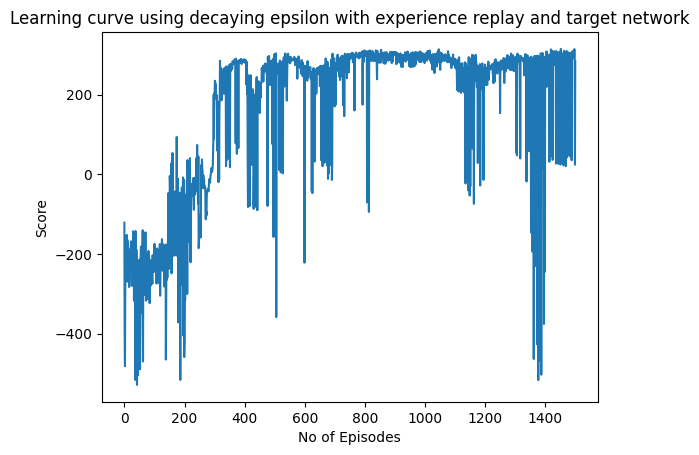

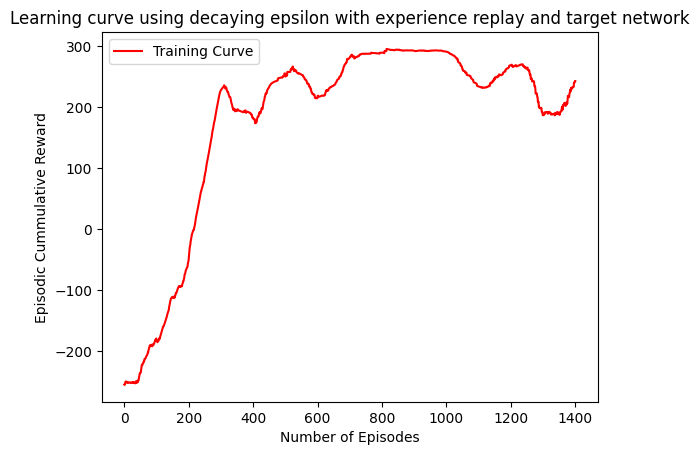

In [13]:
trainer(True, True, True)

Episode Number 0 Average Episodic Reward (over 100 episodes): -121.30


C:\Users\Harsh\AppData\Local\Temp\ipykernel_19044\996469187.py:110: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  states = torch.tensor(states).float().to(self.device)


Episode Number 100 Average Episodic Reward (over 100 episodes): -240.63
Episode Number 200 Average Episodic Reward (over 100 episodes): -160.50
Episode Number 300 Average Episodic Reward (over 100 episodes): -67.21
Episode Number 400 Average Episodic Reward (over 100 episodes): 33.66
Episode Number 500 Average Episodic Reward (over 100 episodes): 74.16
Episode Number 600 Average Episodic Reward (over 100 episodes): -59.74
Episode Number 700 Average Episodic Reward (over 100 episodes): -112.80
Episode Number 800 Average Episodic Reward (over 100 episodes): -49.78
Episode Number 900 Average Episodic Reward (over 100 episodes): -143.50
Episode Number 1000 Average Episodic Reward (over 100 episodes): -235.50
Episode Number 1100 Average Episodic Reward (over 100 episodes): 18.21
Episode Number 1200 Average Episodic Reward (over 100 episodes): 36.68
Episode Number 1300 Average Episodic Reward (over 100 episodes): -12.31
Episode Number 1400 Average Episodic Reward (over 100 episodes): 0.41


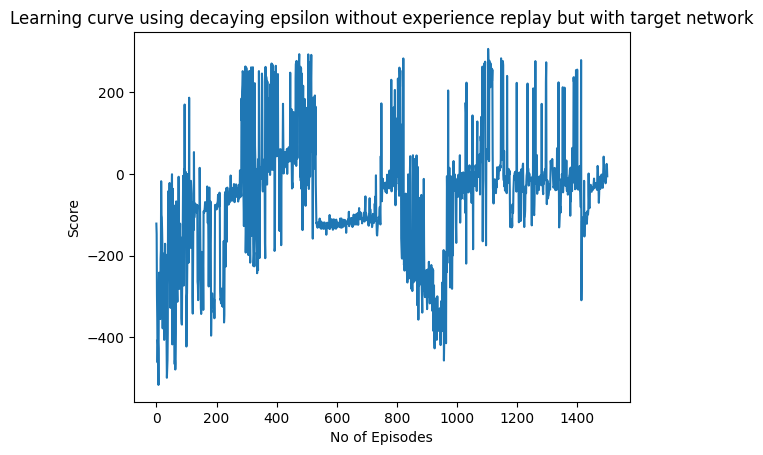

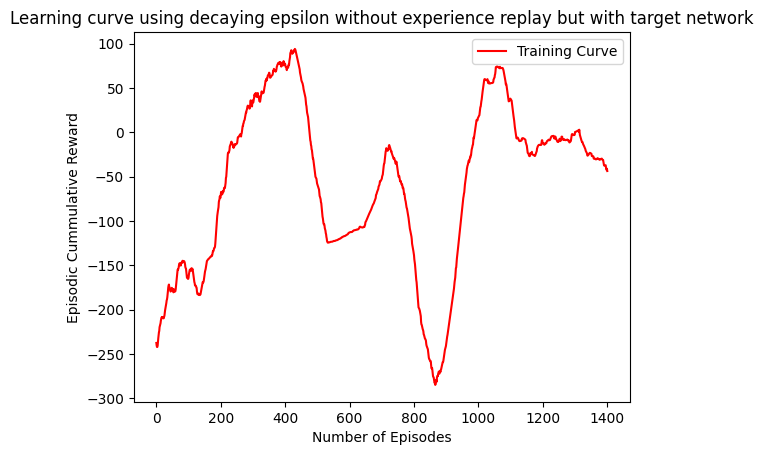

In [17]:
trainer(False, True, False)

Episode Number 0 Average Episodic Reward (over 100 episodes): -121.30
Episode Number 100 Average Episodic Reward (over 100 episodes): -273.58
Episode Number 200 Average Episodic Reward (over 100 episodes): -75.41
Episode Number 300 Average Episodic Reward (over 100 episodes): 2.73
Episode Number 400 Average Episodic Reward (over 100 episodes): -4.39
Episode Number 500 Average Episodic Reward (over 100 episodes): -34.07
Episode Number 600 Average Episodic Reward (over 100 episodes): 51.82
Episode Number 700 Average Episodic Reward (over 100 episodes): 35.07
Episode Number 800 Average Episodic Reward (over 100 episodes): 33.30
Episode Number 900 Average Episodic Reward (over 100 episodes): 25.53
Episode Number 1000 Average Episodic Reward (over 100 episodes): 60.26
Episode Number 1100 Average Episodic Reward (over 100 episodes): 2.28


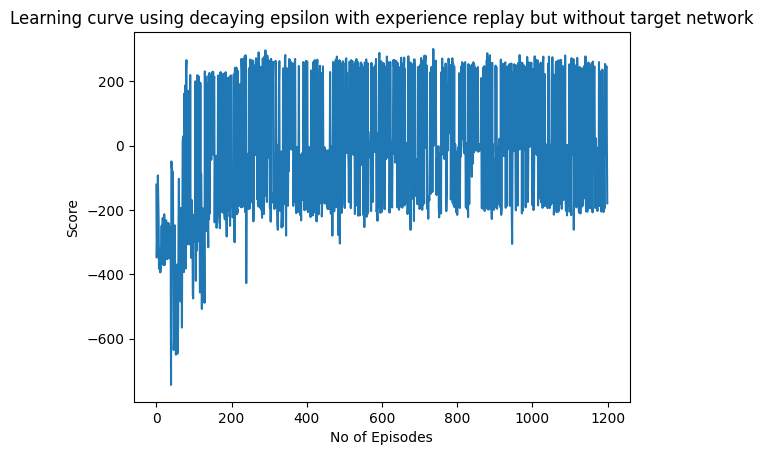

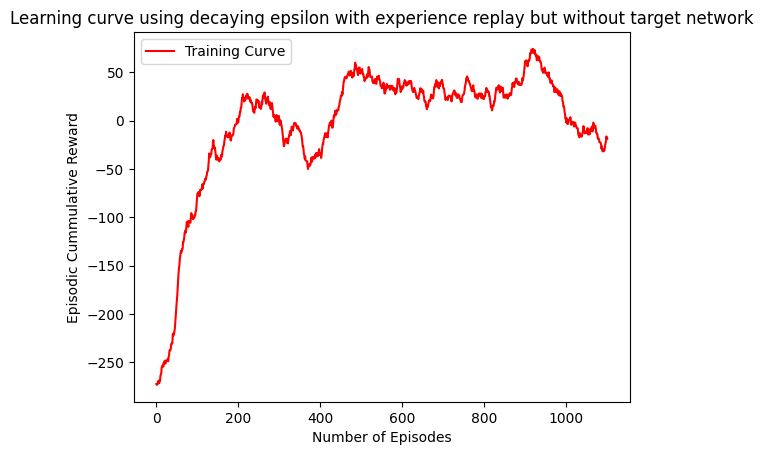

In [21]:
trainer(True, False, False)

In [26]:
    
def render_video(agent, env_name):
    env = gym.make(env_name, render_mode="rgb_array")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter('lunar_landerv1.mp4', fourcc, 30, (600, 400))
    agent.Q.load_state_dict(torch.load('checkpoint.pth'))
    state, _ = env.reset()
    
    done = False
    while not done:
        frame = env.render()
        video.write(frame)
        
        action = agent.select_action(state)

        n_state,reward,terminated,truncated,_ = env.step(action)
        done = terminated or truncated 
        agent.step(True, True, action, reward, n_state, done,_) #To be implemented
        state = n_state       
    env.close()
    video.release()

In [ ]:
video_agent = DQNAgent(state_dim=8, action_dim=4)
render_video(video_agent, 'LunarLander-v2')
